In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import random
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Nadam
from keras.layers import Dense, Conv2D, MaxPooling2D,Flatten,GlobalAveragePooling2D
import seaborn as sns
from tensorflow.keras.utils import Sequence
from PIL import Image
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv('../input/deepweedsx/train_set_labels.csv')
df.head()

,Label,Species
0,20161207-111327-0.jpg,0
1,20170718-095159-2.jpg,0
2,20170811-133439-1.jpg,0
3,20170811-133752-1.jpg,0
4,20170217-114015-0.jpg,0


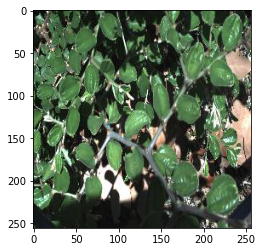

In [3]:
import matplotlib.pyplot as plt
img=plt.imread('../input/deepweedsx/DeepWeeds_Images_256/20161207-111327-0.jpg')
plt.imshow(img)

In [4]:
class IGenerator(Sequence):
    def __init__(self,df,batch_size=16):
        self.keys=df.Label
        self.batch_size=batch_size
        self.df=df
        self.train_data = {}
        
            
    def __len__(self):
        return 1000
    
    def __getitem__(self,idx):
        
        imagedata=[]
        y=[]
        
        keys = np.random.choice(self.keys, size = self.batch_size)
        
        for k in keys:
            try:
                image='../input/deepweedsx/DeepWeeds_Images_256/'+str(k)
                image=plt.imread(image)
                imagedata.append(image)
                
                
                
                y.append(self.df.loc[self.df.Label==k].Species.values)
                
            except:
                pass
       
        imagedata,y = np.array(imagedata),np.array(y)
        y=y.reshape(-1,)
        
        
        
      
        return imagedata , y

In [5]:
import sys
sys.path.append('../input/mobilenet-v3/MobileNetV3-master/MobileNetV3-master/model/layers')
sys.path.append('../input/mobilenet-v3/MobileNetV3-master/MobileNetV3-master/model')
sys.path.append('../input/mobilenet-v3/MobileNetV3-master/MobileNetV3-master')

In [6]:
import mobilenet_v3_small
import mobilenet_v3_large
from mobilenet_v3_small import MobileNetV3_Small
from mobilenet_v3_large import MobileNetV3_Large

In [7]:
def build_model(input_dim=256):
    input1 = tf.keras.layers.Input(shape=(input_dim,input_dim,3))
    model=MobileNetV3_Large([256,256,3],9,include_top=False)
    basemodel=model.build()
    x=basemodel.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1024,activation='relu')(x)  
    x=Dense(1024,activation='relu')(x) 
    x=Dense(1024,activation='relu')(x)
    x=Dense(512,activation='relu')(x) 
    preds=Dense(9,activation='softmax')(x) 
    model=Model(inputs=basemodel.input,outputs=preds)
    return model

In [8]:
model=build_model(256)

In [9]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
model.compile(optimizer='adam',loss= tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [11]:
validdf=pd.read_csv('../input/deepweedsx/test_set_labels.csv')
validdf.head()

,Label,Species
0,20160928-141107-0.jpg,0
1,20160928-141135-0.jpg,0
2,20161207-110730-0.jpg,0
3,20161207-110850-0.jpg,0
4,20161207-112015-0.jpg,0


In [12]:
filepath = "./model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [13]:
print(len(df))
print(len(validdf))

15007
2501


In [14]:
history=model.fit(IGenerator(df=df),steps_per_epoch =900,epochs=50,verbose=1,validation_data=IGenerator(df=validdf),validation_steps=150,callbacks=callbacks_list)

Epoch 1/50
900/900 [==============================] - ETA: 0s - loss: 1.4922 - accuracy: 0.5137
Epoch 00001: val_accuracy improved from -inf to 0.46250, saving model to ./model.hdf5
900/900 [==============================] - 187s 208ms/step - loss: 1.4922 - accuracy: 0.5137 - val_loss: 1.9552 - val_accuracy: 0.4625
Epoch 2/50
900/900 [==============================] - ETA: 0s - loss: 1.2716 - accuracy: 0.5499
Epoch 00002: val_accuracy did not improve from 0.46250
900/900 [==============================] - 132s 147ms/step - loss: 1.2716 - accuracy: 0.5499 - val_loss: 1.5379 - val_accuracy: 0.4333
Epoch 3/50
900/900 [==============================] - ETA: 0s - loss: 1.1891 - accuracy: 0.5656
Epoch 00003: val_accuracy improved from 0.46250 to 0.56458, saving model to ./model.hdf5
900/900 [==============================] - 116s 129ms/step - loss: 1.1891 - accuracy: 0.5656 - val_loss: 1.1931 - val_accuracy: 0.5646
Epoch 4/50
900/900 [==============================] - ETA: 0s - loss: 1.1370 

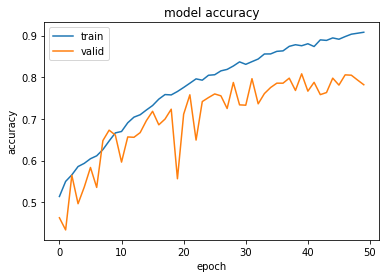

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

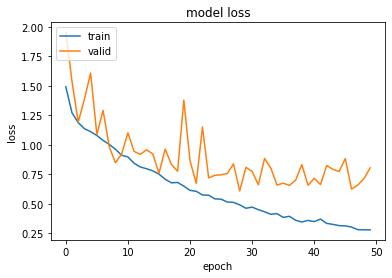

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [17]:
img=plt.imread('../input/deepweedsx/DeepWeeds_Images_256/20170718-095159-2.jpg')
img=np.array(img)
img=img.reshape(1,256,256,3)

In [18]:
model.predict(img)

array([[0.49413466, 0.21342784, 0.00052284, 0.00192411, 0.00779544,
        0.11898092, 0.00516952, 0.08215351, 0.07589115]], dtype=float32)